# Get the Data

In [5]:
# Download the data
import os
import tarfile
from six.moves import urllib
DOWNLOAD_ROOT= "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH= os.path.join ("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing.tgz"

def fetch_housing_data(housing_url= HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url,tgz_path)
    housing_tgz= tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()



In [6]:
fetch_housing_data()

import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return  pd.read_csv(csv_path)
housing = load_housing_data()
housing.head()

HTTPError: HTTP Error 404: Not Found

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize = (20,15)) # histograms with 50 bins
plt.rcParams["patch.force_edgecolor"] = True # enables bin edges
plt.show()

In [ ]:
housing.info()

## Test Train Split

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

In [ ]:
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat']<5, 5.0, inplace=True)
housing['income_cat'].hist() #Data is not stratified, stratified in next cell


## Stratification

In [ ]:
# to maintain the test data from the same median group we need to stratify as shown below, prevents sample bias
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size = 0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


In [ ]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

In [ ]:
strat_train_set['income_cat'].value_counts()/len(strat_train_set)

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace = True)# This drops the income_cat col as we do not need it anymore, only used for stratification


In [ ]:
strat_train_set.head()

# Visualize the Data

In [ ]:
plt.rcParams["patch.force_edgecolor"] = True # enables bin edges
housing.plot(kind='scatter', x='longitude', y='latitude')


In [ ]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

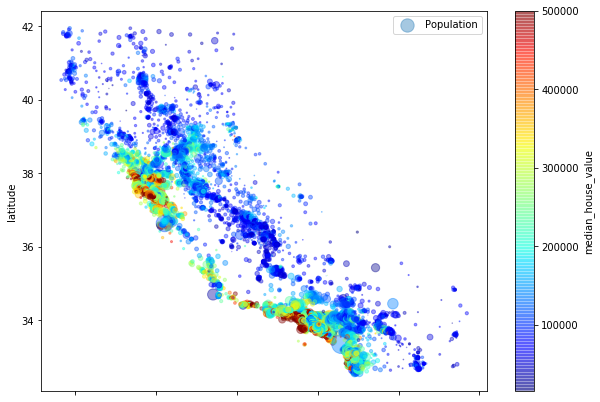

In [13]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,s=housing['population']/100, label='Population', figsize=(10,7), c='median_house_value', cmap=plt.get_cmap('jet'),colorbar='True',)
plt.legend()


In [14]:
corr_matrix= housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
income_cat            0.643892
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

## Correlation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025F362847B8>,
      dtype=object)

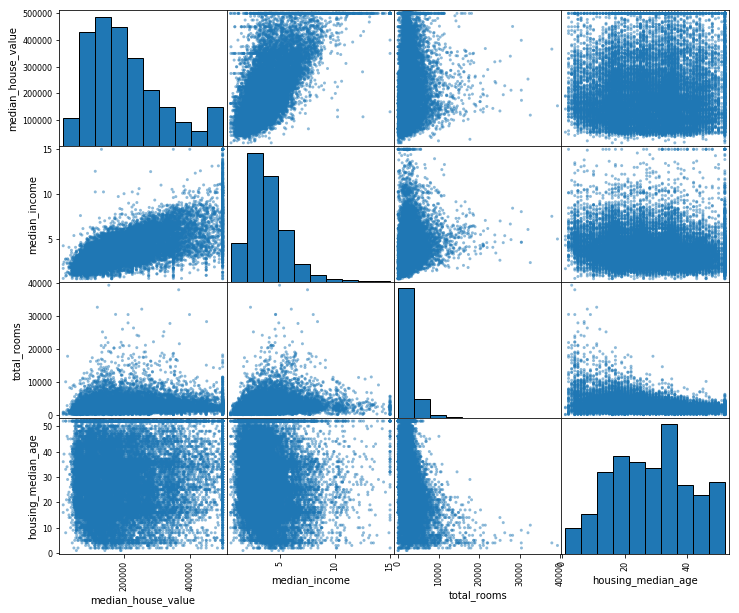

In [15]:
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,10))

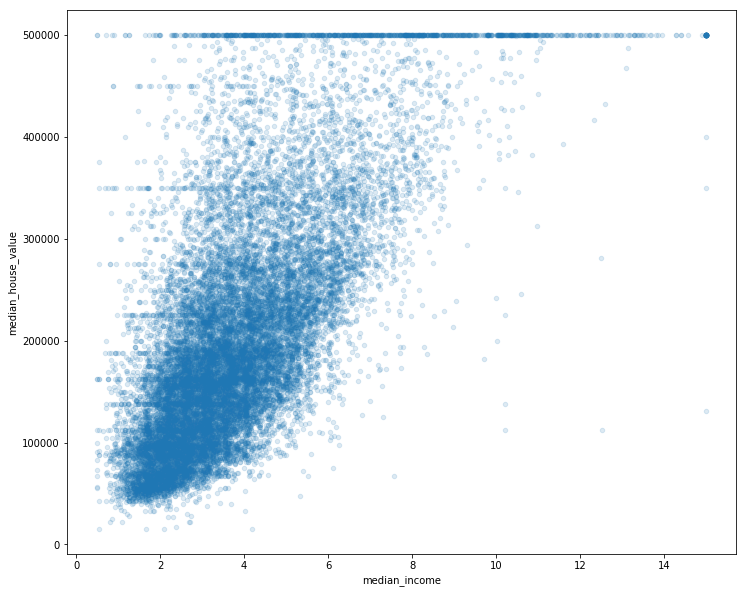

In [16]:
housing.plot(kind= 'scatter', x='median_income', y='median_house_value', figsize=(12,10), alpha=0.15)

In [17]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['pop_per_household'] = housing['population']/housing['households']
corr_matrix= housing.corr() # this line is needed everytime we make changes to the DF
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value     1.000000
median_income          0.688075
income_cat             0.643892
rooms_per_household    0.151948
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
pop_per_household     -0.023737
population            -0.024650
longitude             -0.045967
latitude              -0.144160
bedrooms_per_room     -0.255880
Name: median_house_value, dtype: float64

In [18]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

# Data Cleaning

In [19]:
from sklearn.preprocessing import Imputer # Imputing: Replacing missing values
from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy='median') # Create an instance
housing_num=housing.drop("ocean_proximity", axis = 1) # Median can only work on numerical, hence remove text col
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [20]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [21]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [22]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame (X, columns=housing_num.columns)

In [23]:
housing_cat = housing['ocean_proximity']
housing_cat_encoded, housing_categories = housing_cat.factorize()
print(housing_cat_encoded[:10])
print(housing_cat[:10])

[0 0 1 2 0 2 0 2 0 0]
17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object


In [24]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1,1)
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat_reshaped)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [25]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [26]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [27]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [28]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = [list(housing.columns).index(col) for col in ('total_rooms', 'total_bedrooms', 'population', 'households')]
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix]/X[:, household_ix]
        population_per_household = X[:,population_ix]/X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:, rooms_ix]
            return np.c_[X, rooms_per_household,population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household,population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
            
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")),
                         ('attribs_adder', CombinedAttributesAdder()),
                         ('std_scaler', StandardScaler()),])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [31]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

## Creating the Transformation Pipeline

In [32]:
# Warning: earlier versions of the book applied different transformations to different columns using a solution based on a DataFrameSelector transformer and a FeatureUnion (see below). It is now preferable to use the ColumnTransformer class
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer ([("num", num_pipeline, num_attribs),("cat", OneHotEncoder(), cat_attribs),])
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 16)

# Train the Data

In [33]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
housing.iloc[:5]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [34]:
# Check the fit predictions
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ",  lin_reg.predict(some_data_prepared), "\n for labels:", list(some_labels))

Predictions:  [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879] 
 for labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [35]:
# Check the quality of fit with RMSE
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [36]:
from sklearn.tree import DecisionTreeRegressor # Used to fit complex non-linear relationships
tree_reg = DecisionTreeRegressor(random_state=42) # Please see Chap 6 on more details on Decision Tree
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [37]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse =np.sqrt(tree_mse)
tree_mse

0.0

In [38]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators = 10, random_state = 42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

# Fine Tune the model

## Cross Validation

### Validation - Tree Model

In [39]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
def display_scores(scores):
    print ("Scores:", scores)
    print ("Mean:", scores.mean())
    print ("Standard deviation", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation 2439.4345041191004


### Validation - Linear Model

In [40]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation 2731.674001798346


### Validation - Random Forest Model

In [41]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation 2298.353351147122


### Validation - Support Vector Machine Model

In [42]:
from sklearn.svm import SVR
svm_reg = SVR(kernel="linear",gamma="auto",C=1000)
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions_svm = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions_svm)
svm_rmse = np.sqrt(svm_mse)
svm_rmse


70256.10469475007

## Grid Search

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features' : [2,4,6,8]}, # Trying 12 combinations of hyperparameters
    {'bootstrap':[False], 'n_estimators' : [3,10], 'max_features': [2,3,4]},
]
forest_reg = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [45]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [46]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.05791727153 {'max_features': 2, 'n_estimators': 3}
55627.16171305252 {'max_features': 2, 'n_estimators': 10}
53384.57867637289 {'max_features': 2, 'n_estimators': 30}
60965.99185930139 {'max_features': 4, 'n_estimators': 3}
52740.98248528835 {'max_features': 4, 'n_estimators': 10}
50377.344409590376 {'max_features': 4, 'n_estimators': 30}
58663.84733372485 {'max_features': 6, 'n_estimators': 3}
52006.15355973719 {'max_features': 6, 'n_estimators': 10}
50146.465964159885 {'max_features': 6, 'n_estimators': 30}
57869.25504027614 {'max_features': 8, 'n_estimators': 3}
51711.09443660957 {'max_features': 8, 'n_estimators': 10}
49682.25345942335 {'max_features': 8, 'n_estimators': 30}
62895.088889905004 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.14484390074 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.399594730654 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52725.01091081235 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [47]:
cat_encoder = full_pipeline.named_transformers_["cat"]

list(cat_encoder.categories_[0])

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [48]:
feature_importances_grid = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances_grid, attributes), reverse=True)

[(0.3661589806181342, 'median_income'),
 (0.1647809935615905, 'INLAND'),
 (0.10879295677551573, 'pop_per_hhold'),
 (0.07334423551601242, 'longitude'),
 (0.0629090704826203, 'latitude'),
 (0.05641917918195401, 'rooms_per_hhold'),
 (0.05335107734767581, 'bedrooms_per_room'),
 (0.041143798478729635, 'housing_median_age'),
 (0.014874280890402767, 'population'),
 (0.014672685420543237, 'total_rooms'),
 (0.014257599323407807, 'households'),
 (0.014106483453584102, 'total_bedrooms'),
 (0.010311488326303787, '<1H OCEAN'),
 (0.002856474637320158, 'NEAR OCEAN'),
 (0.00196041559947807, 'NEAR BAY'),
 (6.028038672736599e-05, 'ISLAND')]

## Randomized CV Search

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators': randint (low =1, high = 200), 'max_features' : randint (low =1, high = 8),} # Trying 12 combinations of hyperparameters   }

forest_reg = RandomForestRegressor(random_state=42)

rnd_search = RandomizedSearchCV(forest_reg, param_distributions = param_distribs, cv=5, scoring = 'neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025F3AECD6D8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025F3AECD7F0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [50]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [51]:
feature_importances_rnd = rnd_search.best_estimator_.feature_importances_
feature_importances_rnd

array([7.24699052e-02, 6.38080322e-02, 4.27504395e-02, 1.65343807e-02,
       1.56100762e-02, 1.60929106e-02, 1.52149598e-02, 3.45178404e-01,
       5.74445360e-02, 1.08468449e-01, 7.05907498e-02, 8.77441303e-03,
       1.60563229e-01, 6.10403994e-05, 3.08961266e-03, 3.34886200e-03])

In [52]:
attributes

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [53]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances_rnd, attributes), reverse=True)

[(0.34517840438011976, 'median_income'),
 (0.16056322891587674, 'INLAND'),
 (0.10846844860879656, 'pop_per_hhold'),
 (0.0724699051555905, 'longitude'),
 (0.07059074984842854, 'bedrooms_per_room'),
 (0.06380803224443843, 'latitude'),
 (0.05744453597184107, 'rooms_per_hhold'),
 (0.042750439456624885, 'housing_median_age'),
 (0.016534380739553062, 'total_rooms'),
 (0.016092910597195798, 'population'),
 (0.015610076150868497, 'total_bedrooms'),
 (0.015214959838627945, 'households'),
 (0.008774413032023278, '<1H OCEAN'),
 (0.0033488619987510427, 'NEAR OCEAN'),
 (0.0030896126618977565, 'NEAR BAY'),
 (6.104039936629336e-05, 'ISLAND')]

In [54]:
cat_one_hot_attribs

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

## Test your Model

In [55]:
final_model = rnd_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy() # removed output (med_house_value from input DF)
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error (y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [56]:
final_rmse

46910.92117024934

In [57]:
from scipy import stats
confidence = 0.95
squared_errors =(final_predictions - y_test)**2
mean = squared_errors.mean()
m = len(squared_errors)
np.sqrt(stats.t.interval(confidence,m-1,loc=np.mean(squared_errors),scale=stats.sem(squared_errors)))

array([44945.41068188, 48797.32686039])

# Try SVM with param grid search

In [58]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [30000,100000]},
        {'kernel': ['rbf'], 'C': [1000.0],
         'gamma': [ 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'kernel': ['linear'], 'C': [30000, 100000]}, {'kernel': ['rbf'], 'C': [1000.0], 'gamma': [0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [59]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70352.61867210406

In [60]:
grid_search.best_params_

{'C': 100000, 'kernel': 'linear'}

In [61]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("median_house_value", axis = 1)
y_test = strat_test_set["median_house_value"].copy() # removed output (med_house_value from input DF)
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error (y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [62]:
final_rmse

68100.27760269104

# Try SVM with random grid search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal


param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

rnd_search.best_params_